In [2]:
import gensim
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

import matplotlib.pyplot as plt 

from sklearn.pipeline import Pipeline

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

os.chdir('Terms_for_onedrive')
from NLP_function import *
os.chdir('In_Database')

# Compare Models

In [ ]:
df = pd.read_excel('tokenizing_all_terms.xlsx')
df.head()

In [ ]:
X,Y = read_dataset('tokenizing_train.csv', index=102, lan='en')

vectorizer  = CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 10))
transformer = TfidfTransformer()

X = vectorizer.fit_transform(X)
X_tfidf = transformer.fit_transform(X)

# print(X.toarray()[0].shape)
print('number of features:',X_tfidf.toarray()[0].shape[0])
print('number of sample:', len(X_tfidf.toarray()))

training SGD


C:\Users\Jingz\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


training ASGD
training Perceptron
training Passive-Aggressive I
training Passive-Aggressive II
training SAG


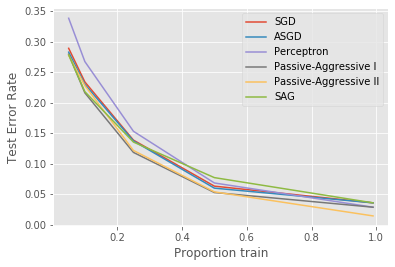

In [102]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds  = 20

classifiers = [
    #("SGD", SGDClassifier(max_iter=100)), 
    ("ASGD", SGDClassifier(average=True)), 
    ("Perceptron", Perceptron()), 
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge', C=1.0, tol=1e-4)),
    #("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge', C=1.0, tol=1e-4)), 
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / X.shape[0]))   

    ("Linear SVM", SVC(kernel="linear", C=0.025)),  
   #('RBF SVM', SVC(gamma=2, C=1)),                 
   #('Gaussian Process', GaussianProcessClassifier(1.0 * RBF(1.0))),   
   #('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)),   
   #("Decision Tree", DecisionTreeClassifier(max_depth=5)), 
    ("Neural Net", MLPClassifier(alpha=1, max_iter=1000)),  
   # ("AdaBoost", AdaBoostClassifier()), 
   # ("QDA", QuadraticDiscriminantAnalysis())     
    
]

xx = 1. - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
            train_test_split(X, Y, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_)) 
    plt.plot(xx, yy, label=name)
    
plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

#######################################################################################

# Import and Split

In [ ]:
X,Y = read_dataset('Terms/cli.tokenizing_train.csv', index=102, lan='en')
print(Y.value_counts().head())

In [ ]:
my_tags = pd.unique(Y).tolist()
print(my_tags)
plt.figure(figsize=(10,4))
Y.value_counts().plot(kind='bar')

In [109]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state = 42)
my_tags = pd.unique(y_test).tolist()

print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape, 'x_test shape:', x_test.shape, 'y_test shape:', y_test.shape)
print('levels of y_test :', len(pd.unique(y_test))) 
print('levels of y_train :', len(pd.unique(y_train))) 

x_train shape: (470,) y_train shape: (470,) x_test shape: (202,) y_test shape: (202,)
levels of y_test : 15
levels of y_train : 17


# Fit models

### (soft-margin) Linear Support Vector Machine

In [ ]:
sgd = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                #('hash', HashingVectorizer(n_features=2**6)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None)),
               ])
sgd.fit(x_train, y_train)

y_pred = sgd.predict(x_test)
my_tags = pd.unique(y_test).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

##### Confusion-Matrix

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=y_test.drop_duplicates().values, yticklabels=y_test.drop_duplicates().values,
            center=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### save model

In [13]:
with open('M_SGDClassifier.pickle', 'wb') as handle:
    pickle.dump(sgd, handle, protocol=pickle.HIGHEST_PROTOCOL)  

### Logistic Regression

In [ ]:
logreg = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)
my_tags = pd.unique(y_pred).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

##### save model

In [15]:
with open('M_LogisticRegression.pickle', 'wb') as handle:
    pickle.dump(logreg, handle, protocol=pickle.HIGHEST_PROTOCOL)  

### Passive Aggressive Classifier

In [ ]:
PacI = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                ('tfidf', TfidfTransformer()),
                ('clf',   PassiveAggressiveClassifier(loss='hinge', C=1.0, tol=1e-4)),
               ])
PacI.fit(x_train, y_train)


PacII = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                ('tfidf', TfidfTransformer()),
                ('clf',   PassiveAggressiveClassifier(loss='squared_hinge', C=1.0, tol=1e-4)),
               ])
PacII.fit(x_train, y_train)


y_pred = PacII.predict(x_test)
my_tags = pd.unique(y_pred).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

##### save model

In [107]:
with open('M_PassiveAggressiveClassifierII.pickle', 'wb') as handle:
    pickle.dump(PacII, handle, protocol=pickle.HIGHEST_PROTOCOL)  

### Naive Bayes Classifier for Multinomial Models

In [ ]:
nb = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1,4))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
my_tags = pd.unique(y_test).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names = my_tags))

### Random Forest

In [ ]:
rf = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)),
               ])
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
my_tags = pd.unique(y_test).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

#######################################################################################

# Load pretrained model and predict

In [ ]:
with open('M_SGDClassifier.pickle', 'rb') as handle:
    sgd= pickle.load(handle)
with open('M_LogisticRegression.pickle', 'rb') as handle:
    logreg= pickle.load(handle)
    

y_pred = sgd.predict(x_test)
i=93
print(i, 'Predicted_class:', y_pred[i], '; Real_class:', y_test.iloc[i])

y_pred = logreg.predict(x_test)
print(i, 'Predicted_class:', y_pred[i], '; Real_class:', y_test.iloc[i])

##############################################################################################

# Pretrained embedding

### Word2vec and Logistic Regression

learn feature representations for words

In [ ]:
os.chdir('Terms/')

from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("Embedding\Word2Vec\GoogleNews-vectors-negative300.txt", binary=False)
wv.init_sims(replace=True)

In [ ]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

In [ ]:
# BOW average method

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['y_en'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

## Doc2vec and Logistic Regression

learn feature representations for sentences or documents

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df.x_en, df.y_en, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
all_data[:2]